<a href="https://colab.research.google.com/github/lucahuesler/dlv_FindWally/blob/master/Copy_of_waldo_michele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Helper libraries
import os
import math
import numpy as np
import pandas as pd
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Load data from github

In [2]:
!git clone https://github.com/lucahuesler/dlv_FindWally.git

Cloning into 'dlv_FindWally'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 31.25 MiB | 41.78 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [0]:
path_data = '/content/dlv_FindWally/data/data'
path_train = '/content/dlv_FindWally/data/data/train'
path_validation = '/content/dlv_FindWally/data/data/validation'
path_annotations = '/content/dlv_FindWally/data/data/annotations'
ROOT_DIR = os.getcwd()

# Installing Mask R-CNN

**Step 1. Clone the Mask R-CNN GitHub Repository**


In [8]:
# clone into top level folder of project
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [7]:
# check installation
!pip3 show mask-rcnn

**Step 2. Install the Mask R-CNN Library**

The directory has to be set to the MASK_RCNN directory that was created in step 1.

In [11]:
import os
os.chdir('./Mask_RCNN')
!pip3 install -r requirements.txt
!python3 setup.py install 

     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 204kB 14.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=08bc8da4407539a47de7f7af23973c358edd8ca76542feff6728323b59528257
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

Confirmation that the library was installed

In [12]:
!pip3 show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


Import additional configurations from Mask R-CNN GitHub Repository

In [13]:
#Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib

Using TensorFlow backend.


# Training Mask RCNN with Waldo pictures

**Preparation**

Installing weights coco

In [0]:
# Path to trained weights file (file is imported per hand first)
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Configuartion

In [0]:
class WaldoConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "waldo"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + waldo

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

Dataset

In [0]:
#Converting .csv to json
import csv
import json

csvFilePath = '/content/dlv_FindWally/data/data/annotations/annotations.csv'
jsonFilePath = '/content/dlv_FindWally/data/data/annotations/label_data.json'

data = {}
with open(csvFilePath) as csvFile:
  csvReader = csv.DictReader(csvFile)
  for rows in csvReader:
    id = rows['filename'] 
    data[id]=rows

with open(jsonFilePath, 'w') as jsonFile:
  jsonFile.write(json.dumps(data, indent=4))
        

In [0]:
class WaldoDataset(utils.Dataset):

    def load_waldo(self, dataset_dir, subset):
        """Load a subset of the Waldo dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("waldo", 1, "waldo")

        # Train or validation dataset?
        assert subset in ["train", "validation"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "./annotations/label_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # Add images
        polygons = []
        for a in annotations:
          polygons.append([a['xmin'], a['xmax'], a['ymin'], a['ymax']])
          image_path = os.path.join( dataset_dir2,a['filename'])
          image = skimage.io.imread(image_path)
          height, width = image.shape[:2]

          self.add_image(
              "waldo",
              image_id=a['filename'],
              path=image_path,
              width=width, height=height,
              polygons = polygons )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a waldo dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "waldo":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)


    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "waldo":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [0]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = WaldoDataset()
    dataset_train.load_waldo(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = WaldoDataset()
    dataset_val.load_waldo(args.dataset, "validation")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

Training


In [20]:
path_data

'/content/dlv_FindWally/data/data'

In [21]:
if __name__ == '__main__':
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Train Mask R-CNN to detect waldo.')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train'")
    parser.add_argument('--dataset', required=False,
                        metavar='/content/dlv_FindWally/data/data/',
                        help='Directory of the Waldo dataset')
    parser.add_argument('--weights', required=True,
                        metavar=COCO_WEIGHTS_PATH,
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/content/logs",
                        help='Logs and checkpoints directory (default=logs/)')

    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
   
    print("Weights: ", args.weights)
    print("Dataset: ", args.dataset)
    print("Logs: ", args.logs)

    # Configurations
    if args.command == "train":
        config = WaldoConfig()
    else:
        class InferenceConfig(WaldoConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if args.command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=args.logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=args.logs)

    # Select weights file to load
    if args.weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif args.weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()[1]
    elif args.weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = args.weights

    # Load weights
    print("Loading weights ", weights_path)
    if args.weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args.command == "train":
        train(model)
    elif args.command == "splash":
        detect_and_color_splash(model, image_path=args.image,
                                video_path=args.video)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(args.command))

usage: ipykernel_launcher.py [-h]
                             [--dataset /content/dlv_FindWally/data/data/]
                             --weights /content/mask_rcnn_balloon.h5
                             [--logs /content/logs]
                             <command>
ipykernel_launcher.py: error: the following arguments are required: --weights


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
%tb

SystemExit: ignored

# Inspect waldo dataset

**Display images**

In [0]:
# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

In [0]:
print(os.listdir(path_train))
len(os.listdir(path_train))

['4.jpg', '15.jpg', '7.jpg', '21.jpg', '19.jpg', '10.jpg', '9.jpg', '1.jpg', 'Mask_RCNN', '17.jpg', '11.jpg', '8.jpg', '13.jpg', '23.jpg', '20.jpg', '18.jpg', '3.jpg', '12.jpg', '16.jpg', '14.jpg', '2.jpg', '5.jpg', '22.jpg']


23

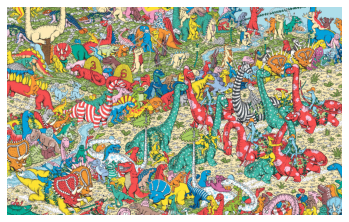

In [0]:
os.chdir(path_train)
img = mpimg.imread('4.jpg')
np.shape(img)

plot_img(img)

**Display samples**

In [0]:
# Load and display random samples
for image_id in path_train:
  img = mpimg.imread(image_id)
  np.shape(img)
  plot_img(img)

IsADirectoryError: ignored